# 基础

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wf
import scipy.signal as sig
from scipy import integrate as inte
from scipy import fft

 ## 常数控制
 dt 时间步长（采样率fs=1/dt）  
 T 模拟时间  

In [2]:
dt = 1/1000 #1ms
T = 10
t = np.arange(0, T, dt)

## utils

In [3]:
def iq_decompose(Ws, Flo):
    i = Ws*sin_singal(freq=Flo)
    q = Ws*sin_singal(freq=Flo, phi=0.25)
    return (i,q)

def iq_compose(i, q, Flo):
    Wlo = (sin_singal(freq=Flo), sin_singal(freq=Flo, phi=0.25)) #本振I,Q
    Ws = i*Wlo[0]+q*Wlo[1]
    return Ws

In [4]:
def noise(data, mean=0, sigma=0.1):
    return data+np.random.normal(mean, sigma, data.shape)

In [5]:
def fft_plot(arr, max_freq=10):
    sample_rate = max_freq * 2
    N = T * sample_rate
    #df = sample_rate / N

    F = fft.fft(arr)
    _freq = fft.fftfreq(N, 1/sample_rate)
    mask = np.where(_freq >= 0)

    #plt.figure(figsize=(8,6))
    plt.plot(_freq[mask], np.log(abs(F[mask])), label="real")
    plt.plot(max_freq, 0, 'r*', markersize=10)

    plt.xlabel("frequency (Hz)", fontsize=14)
    plt.ylabel("$\log(|F|)$", fontsize=14)
    #plt.show()

In [6]:
def butter_lowpass(Fcutoff, order=2):
    b, a = sig.butter(order, Fcutoff*2*dt, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(x, Fcutoff, order=2):
    b, a = sig.butter(order, Fcutoff*2*dt, btype='low', analog=False)
    y = sig.filtfilt(b, a, x)
    return y

## 产生正弦信号
（可选）调整信号相位

In [7]:
def sin_singal(freq, phi=0):
    return np.cos(2*np.pi*(freq*t+phi))

## 低通滤波器参数测试
在此调整低通滤波器参数

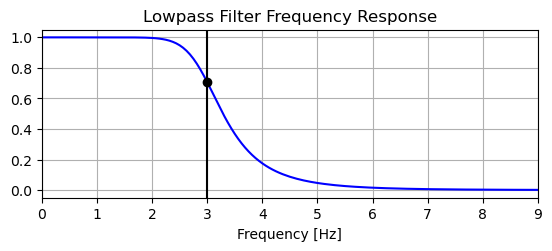

In [8]:
order = 6      
cutoff = 3

b, a = butter_lowpass(cutoff, order)

# Plotting the frequency response.
w, h = sig.freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot((0.5*w)/(np.pi*dt), np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 3*cutoff)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# FM

## FM调制
Ws:singal input  
A:amplitude  
Cfreq:carrier freq  
k:modulate coff  

In [9]:
def fm_mod(Ws, A=1, Cfreq=100, k=10):
    return A*np.cos(2*np.pi*Cfreq*t+2*np.pi*k*np.cumsum(Ws*dt))

In [10]:
Cfreq = 100
s_ori = sin_singal(freq=2)
s_fm = noise(fm_mod(s_ori, Cfreq=Cfreq, k=4), sigma=0.05)

## FM解调：差分法

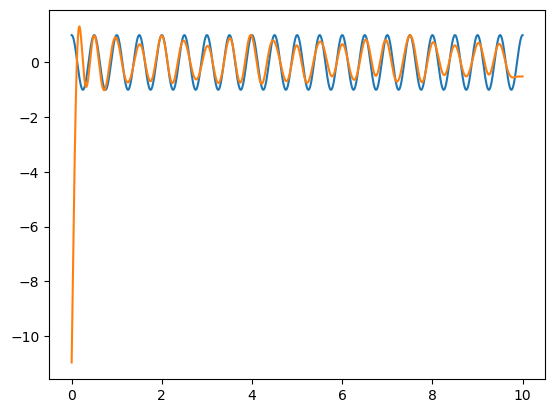

In [11]:
y = np.diff(s_fm)
y[y<0] = 0
rx = butter_lowpass_filter(y, Fcutoff=3, order=6)
rx = rx-np.mean(rx)
rx = rx*2/np.ptp(rx[int(0.25/dt):int(0.75/dt)])
plt.plot(t[0:int(T/dt-1)],s_ori[0:int(T/dt-1)])
plt.plot(t[0:int(T/dt-1)], rx)
plt.show()

## FM解调：I/Q分解

In [12]:
def fm_demod(Ws, Flo=100, Fcutoff=3, order=6):
    data = iq_decompose(Ws=Ws, Flo=Flo)
    i = butter_lowpass_filter(data[0], Fcutoff=Fcutoff, order=6)
    q = butter_lowpass_filter(data[1], Fcutoff=Fcutoff, order=6)
    c = i + 1.j*q
    rx = butter_lowpass_filter(np.diff(np.unwrap(np.angle(c))), Fcutoff=Fcutoff, order=order)
    rx = rx-np.mean(rx)#居中
    rx = rx*2/np.ptp(rx[int(0.25/dt):int(0.75/dt)])#归一
    return rx

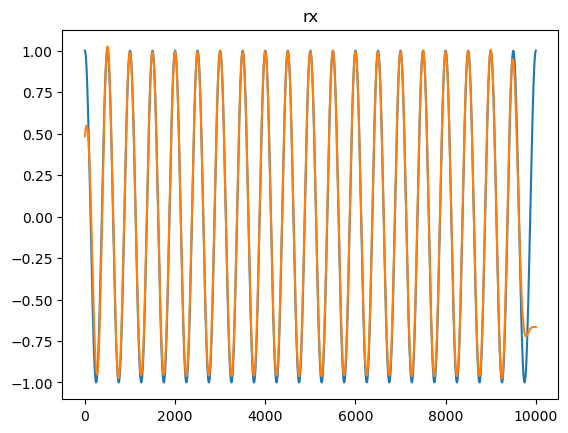

In [13]:
Fcutoff = 3
order=6
rx = fm_demod(s_fm, Flo=Cfreq, Fcutoff=Fcutoff, order=order)
plt.plot(s_ori)
plt.plot(rx)
plt.title('rx')
plt.show()

# FSK

## 2FSK调制

In [14]:
data = [0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0]
Hfreq = 10
Lfreq = 5
d_tau = 1/2 #transmit speed
Hsig = sin_singal(freq=Hfreq)
Lsig = sin_singal(freq=Lfreq,phi=0.5)
fsk_sig =np.empty(len(t))
for i in range(0, len(t)):
    
    if data[int(i*dt/d_tau)]:
        fsk_sig[i] = Hsig[i]
    else:
        fsk_sig[i] = Lsig[i]

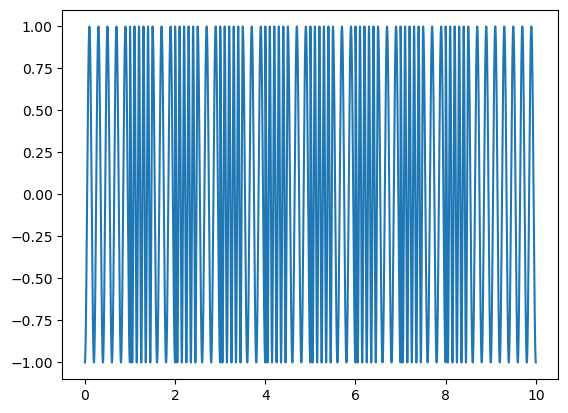

In [15]:
plt.plot(t, fsk_sig)

## 2FSK解调

-0.42819153375649366
0.06838796986013307
0.3687452677137158
0.13196124443928448
0.3604399564310032
0.13386374845357304
0.3593829614919208
0.13425183566330298
0.3595798845632618
0.1343491652939783
0.3601905452755551
0.13296025302712197
0.3591144140061177
0.1349372578880705
0.35758097827385166
0.1395461212830915
0.34468853501077573
0.17656376394274373
-0.05872374833182464
0.027381657642155548


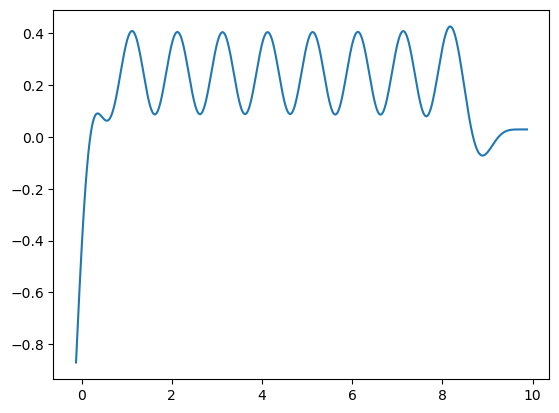

In [22]:
LOsig = Hsig
fsk_i = fsk_sig*LOsig
fsk_i = butter_lowpass_filter(fsk_i, Fcutoff=1, order=6)
# for i in range(0, len(fsk_i)):
#     if fsk_i[i]>0.25: ##阈限
#         fsk_i[i] = 1
#     else:
#         fsk_i[i] = 0
for i in range(int(0.25*d_tau/dt), len(t), int(d_tau/dt)): #range起始处适当延迟
    print(fsk_i[i])

# plt.plot(t[::int(d_tau/dt)],data)
plt.plot(t-int(0.25*d_tau/dt)*dt, fsk_i)
#data = [0,0,1,0,1,0,1,0,0,0]

# PSK

## 2PSK调制

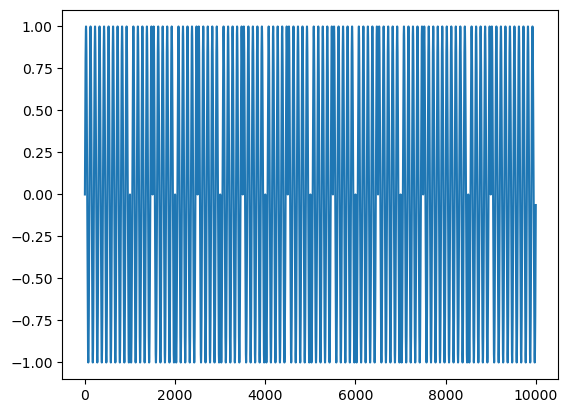

In [17]:
ori_data = [0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0]
data = ori_data
for i in range(0,len(data)):
    if data[i] == 0:
        data[i] = -1
d_tau = 1/2 #transmit speed
Cfreq = 10
s_data = np.empty(len(t))
for i in range(0, len(t)):    
    s_data[i]=data[int(i*dt/d_tau)]
#psk_sig = noise(iq_compose(0, s_data, Cfreq))
psk_sig = iq_compose(0, s_data, Cfreq)
plt.plot(psk_sig)

## 2PSK解调

1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0


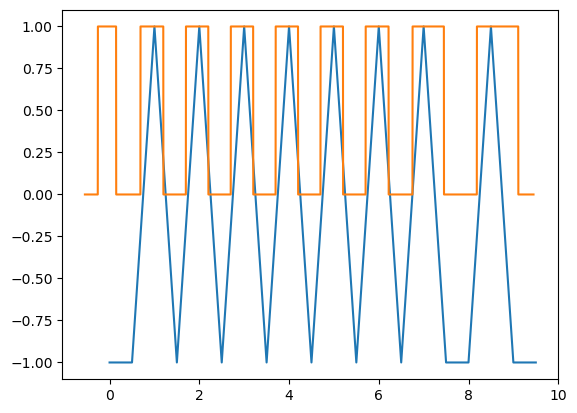

In [18]:
psk_i,_ = p = butter_lowpass_filter(iq_decompose(psk_sig, Flo=Cfreq), Fcutoff=1, order=5)

for i in range(0, len(t)):
    if psk_i[i]>0: ##阈限
        psk_i[i] = 1
    else:
        psk_i[i] = 0

for i in range(int(1*d_tau/dt), len(t), int(d_tau/dt)): #range起始处适当延迟
    print(psk_i[i])
plt.plot(t[::int(d_tau/dt)],ori_data)
plt.plot(t-int(1.1*d_tau/dt)*dt, psk_i)
#ori_data = [0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0]

## 4PSK调制

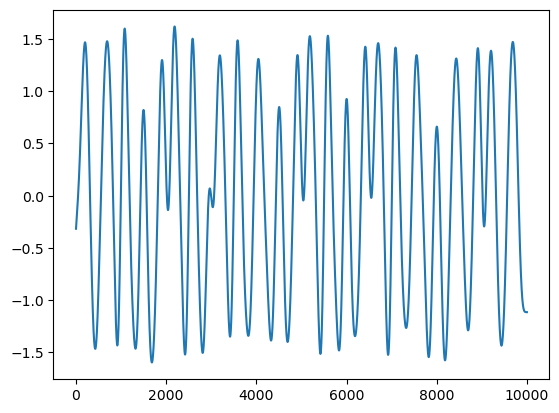

In [19]:
ori_data = [0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,1,0,0,1,0,1,0,1,1,1,1,0,0,0,0]
data = np.asarray(ori_data).reshape(len(ori_data)//2,2)

for i in range(0,len(data)):
    if data[i][0] == 0:
        data[i][0] = -1
    if data[i][1] == 0:
        data[i][1] = -1

d_tau = 1/2 #transmit speed
Cfreq = 2
s_data = np.empty((2,len(t)))
for i in range(0, len(t)):    
    s_data[0][i]=data[int(i*dt/d_tau)][0]
    s_data[1][i]=data[int(i*dt/d_tau)][1]
qpsk_sig = iq_compose(s_data[0], s_data[1], Cfreq)
qpsk_sig = noise(qpsk_sig,sigma=1)
qpsk_sig = butter_lowpass_filter(qpsk_sig, Fcutoff=5, order=6)
plt.plot(qpsk_sig)
plt.show()


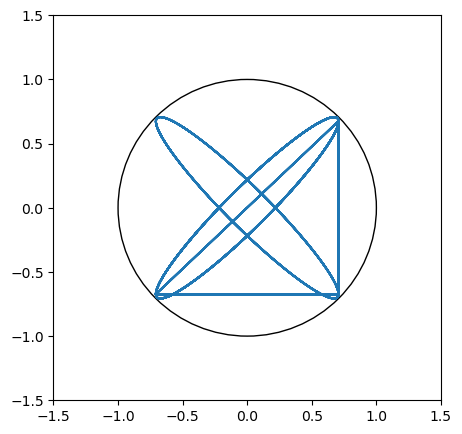

In [20]:
Wlo = (sin_singal(freq=2), sin_singal(freq=2, phi=0.05)) #本振I,Q
plt.figure(figsize=(5,5))
plt.plot(0.707*s_data[0]*Wlo[0],0.707*s_data[1]*Wlo[1])
draw_circle = plt.Circle((0, 0), 1, fill=False)
plt.gcf().gca().add_artist(draw_circle)
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))

plt.show()